# The McCall Search Model

This module was created by QuantEcon.

Minor edits have been made by Rupal Kamdar for teaching purposes.

“Questioning a McCall worker is like having a conversation with an out-of-work friend: ‘Maybe you are setting your sights too high’, or ‘Why did you quit your old job before you had a new one lined up?’ This is real social science: an attempt to model, to understand, human behavior by visualizing the situation people find themselves in, the options they face and the pros and cons as they themselves see them.”

– Robert E. Lucas, Jr.

## Overview

The McCall search model helped transform economists’ way of thinking about labor markets. He modeled the decision problem of unemployed agents directly, in terms of factors such as:

- current and likely future wages  
- impatience  
- unemployment compensation  


To solve the decision problem, he used dynamic programming. Today we set up McCall’s model and adopt the same solution method.

As we’ll see, McCall’s model is not only interesting in its own right but also an excellent vehicle for us to continue learning dynamic programming (which we began with the shortest paths lecture).

Let’s start with some imports:

In [ ]:
!pip install --upgrade quantecon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from quantecon.distributions import BetaBinomial

## The McCall Model


<a id='index-0'></a>
An unemployed worker receives in each period a job offer at wage $ W_t $.

At time $ t $, our worker has two choices:

1. Accept the offer and work permanently at constant wage $ W_t $.  
1. Reject the offer, receive unemployment compensation $ c $, and reconsider next period.  


The wage sequence is assumed to be IID with probability mass function $ \phi $. Note that it is a probability mass function (and not a probability density function), because its support consists of discrete points.

Thus $ \phi (w) $ is the probability of observing wage offer $ w $ in the set $ w_1, \ldots, w_n $.

The worker is infinitely lived and aims to maximize the expected discounted sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t Y_t
$$

The constant $ \beta $ lies in $ (0, 1) $ and is called a **discount factor**.

The smaller is $ \beta $, the more the worker discounts future utility relative to current utility.

The variable  $ Y_t $ is income, equal to

- his wage $ W_t $ when employed  
- unemployment compensation $ c $ when unemployed  

### A Trade-Off

The worker faces a trade-off:

- Waiting too long for a good offer is costly, since the future is discounted.  
- Accepting too early is costly, since better offers might arrive in the future.  


To decide optimally in the face of this trade-off, we use dynamic programming.

Dynamic programming can be thought of as a two-step procedure that

1. first assigns values to “states” and  
1. then deduces optimal actions given those values  


We’ll go through these steps in turn.

### The Value Function

In order to optimally trade-off current and future rewards, we need to think about two things:

1. the current payoffs we get from different choices  
1. the different states that those choices will lead to in next period (in this case, either employment or unemployment)  


To weigh these two aspects of the decision problem, we need to assign *values* to states.

To this end, let $ v^*(w) $ be the total lifetime *value* accruing to an unemployed worker who enters the current period unemployed but with wage offer $ w $ in hand.

More precisely, $ v^*(w) $ denotes the value of the objective function [(1)](https://lectures.quantecon.org/mccall_model_with_separation.html#equation-objective) when an agent in this situation makes *optimal* decisions now and at all future points in time.

Of course $ v^*(w) $ is not trivial to calculate because we don’t yet know what decisions are optimal and what aren’t!

But think of $ v^* $ as a function that assigns to each possible wage $ w $ the maximal lifetime value that can be obtained with that offer in hand.

A crucial observation is that this function $ v^* $ must satisfy the recursion


<a id='equation-odu-pv'></a>
$$
v^*(w)
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta \sum_{w'} v^*(w') \phi (w')
    \right\} \tag{1}
$$

for every possible $ w $  in $ w_1, \ldots, w_n $.

This important equation is a version of the **Bellman equation**, which is
ubiquitous in economic dynamics and other fields involving planning over time.

The intuition behind it is as follows:

- the first term inside the max operation is the lifetime payoff from accepting current offer $ w $, since  


$$
w + \beta w + \beta^2 w + \cdots = \frac{w}{1 - \beta}
$$

- the second term inside the max operation is the **continuation value**, which is the lifetime payoff from rejecting the current offer and then behaving optimally in all subsequent periods  


If we optimize and pick the best of these two options, we obtain maximal lifetime value from today, given current offer $ w $.

But this is precisely $ v^*(w) $, which is the l.h.s. of [(1)](#equation-odu-pv).

### The Optimal Policy

Suppose for now that we are able to solve [(1)](#equation-odu-pv) for the unknown
function $ v^* $.

Once we have this function in hand we can behave optimally (i.e., make the
right choice between accept and reject).

All we have to do is select the maximal choice on the r.h.s. of [(1)](#equation-odu-pv).

The optimal action is best thought of as a **policy**, which is, in general, a map from
states to actions.

In our case, the state is the current wage offer $ w $.

Given *any* $ w $, we can read off the corresponding best choice (accept or
reject) by picking the max on the r.h.s. of [(1)](#equation-odu-pv).

Thus, we have a map from $ \mathbb R $ to $ \{0, 1\} $, with 1 meaning accept and 0 meaning reject.

We can write the policy as follows

$$
\sigma(w) := \mathbf{1}
    \left\{
        \frac{w}{1 - \beta} \geq c + \beta \sum_{w'} v^*(w') \phi (w')
    \right\}
$$

Here $ \mathbf{1}\{ P \} = 1 $ if statement $ P $ is true and equals 0 otherwise.

We can also write this as

$$
\sigma(w) := \mathbf{1} \{ w \geq \bar w \}
$$

where

$$
\bar w := (1 - \beta) \left\{ c + \beta \sum_{w'} v^*(w') \phi (w') \right\}
$$

Here $ \bar w $ is a constant depending on $ \beta, c $ and the wage distribution called the *reservation wage*.

The agent should accept if and only if the current wage offer exceeds the reservation wage.

Clearly, we can compute this reservation wage if we can compute the value function.

## Computing the Optimal Policy

To put the above ideas into action, we need to compute the value function at
points $ w_1, \ldots, w_n $.

In doing so, we can identify these values with the vector $ v^* = (v^*_i) $ where $ v^*_i := v^*(w_i) $.

In view of [(1)](#equation-odu-pv), this vector satisfies the nonlinear system of equations


<a id='equation-odu-pv2'></a>
$$
v^*_i
= \max \left\{
        \frac{w_i}{1 - \beta}, \, c + \beta \sum_{j} v^*_j \phi (w_j)
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{2}
$$

### The Algorithm

To compute this vector, we proceed as follows:

Step 1: pick an arbitrary initial guess $ v \in \mathbb R^n $.

Step 2: compute a new vector $ v' \in \mathbb R^n $ via


<a id='equation-odu-pv2p'></a>
$$
v'_i
= \max \left\{
        \frac{w_i}{1 - \beta}, \, c + \beta \sum_{j} v_j \phi (w_j)
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{3}
$$

Step 3: calculate a measure of the deviation between $ v $ and $ v' $, such as $ \max_i |v_i - v_i'| $.

Step 4: if the deviation is larger than some fixed tolerance, set $ v = v' $ and go to step 2, else continue.

Step 5: return $ v $.

This algorithm returns an arbitrarily good approximation to the true solution
to [(2)](#equation-odu-pv2), which represents the value function.

(Arbitrarily good means here that the approximation converges to the true
solution as the tolerance goes to zero)

### Implementation

Here’s the distribution of wage offers we’ll work with

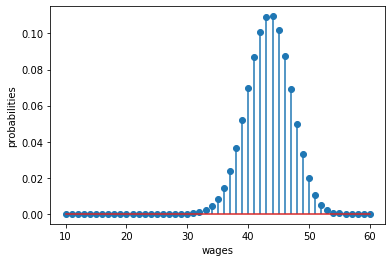

In [2]:
n, a, b = 50, 200, 100
dist = BetaBinomial(n, a, b)
ϕ_vals = dist.pdf()

w_min, w_max = 10, 60
w_vals = np.linspace(w_min, w_max, n+1)

fig, ax = plt.subplots()
ax.stem(w_vals, ϕ_vals, label='$\phi (w\')$', use_line_collection=True)
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

First, let’s have a look at the sequence of approximate value functions that
the algorithm above generates.

Default parameter values are embedded in the function.

Our initial guess $ v $ is the value of accepting at every given wage.

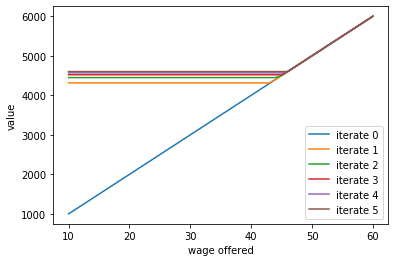

In [3]:
def plot_value_function_seq(ax, #axis of the graph
                            c=25, #unemployment benefit
                            β=0.99, #discount factor
                            w_vals=w_vals, #values that the wage can take
                            ϕ_vals=ϕ_vals, #the probabilities that a given wage occurs (the pmf)
                            num_plots=6): #number of iterations

    v = w_vals / (1 - β)       #initial guess for v
    v_next = np.empty_like(v)  #create an empty array for the next guess of v
    
    for i in range(num_plots): #for a fixed number of times, NOT UNTIL "CONVERGENCE"
        ax.plot(w_vals, v, label=f"iterate {i}") #plot the current guess for v
        
        #update guess
        for j, w in enumerate(w_vals): #j will go from 0, 1,...50 and w goes from 10, 11,...60
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * ϕ_vals)
            v_next[j] = max(stop_val, cont_val)
        v[:] = v_next           #set v to the newest guess for v

        
fig, ax = plt.subplots()
plot_value_function_seq(ax)
ax.set_xlabel('wage offered')
ax.set_ylabel('value')
ax.legend(loc='lower right')
plt.show()

Here’s more serious iteration effort, that continues until measured deviation
between successive iterates is below tol.

In [4]:
def compute_reservation_wage(c=25,
                             β=0.99,
                             w_vals=w_vals,
                             ϕ_vals=ϕ_vals,
                             tol=1e-6):

    # == First compute the value function == #

    v = w_vals / (1 - β)      #initial guess for v
    v_next = np.empty_like(v) #empty array for the next guess of v
    
    error = tol + 1           #set the error to some number bigger than the tolerance
    while error > tol:        #run until the error is less than the tolerance

        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * ϕ_vals)
            v_next[j] = max(stop_val, cont_val)

        error = np.max(np.abs(v_next - v)) 
        v[:] = v_next         #copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * ϕ_vals))

Let’s compute the reservation wage at the default parameters

In [5]:
compute_reservation_wage()

47.31649971002487

### Comparative Statics

Now we know how to compute the reservation wage, let’s see how it varies with
parameters.

In particular, let’s look at what happens when we change $ \beta $ and
$ c $.

In [6]:
grid_size = 25

c_vals = np.linspace(10.0, 30.0, grid_size) #create a grid over unemployment benefit values
β_vals = np.linspace(0.9, 0.99, grid_size)  #create a grid over discount factor values

R = np.empty((grid_size, grid_size)) #an empty array that is gridsize by gridsize

#calculate the reservation wage for all combinations of c and B in the grids
for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        R[i, j] = compute_reservation_wage(c=c, β=β)

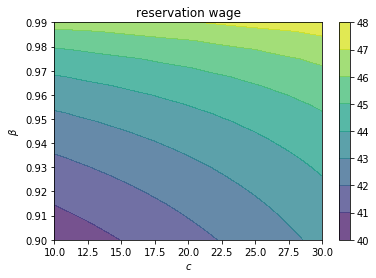

In [7]:
fig, ax = plt.subplots()
cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
plt.colorbar(cs1, ax=ax) #include a colorbar legend

ax.set_title("reservation wage")
ax.set_xlabel("$c$")
ax.set_ylabel("$β$")

plt.show()

As expected, the reservation wage increases both with patience and with
unemployment compensation.